In [75]:
import requests
from bs4 import BeautifulSoup
import sqlite3
import time
import pandas as pd

class GourmetAnalysis:
    def __init__(self, db_path):
        self.db_path = db_path
        self.conn = sqlite3.connect(db_path)
        self.cursor = self.conn.cursor()

    def fetch_data(self, query):
        """クエリを発行してデータを取得"""
        return pd.read_sql_query(query, self.conn)

    def close_connection(self):
        """データベース接続を閉じる"""
        self.conn.close()

    def create_table(self):
        """テーブル作成"""
        self.cursor.execute("""
        CREATE TABLE IF NOT EXISTS gourmet_reviews (
            id INTEGER PRIMARY KEY AUTOINCREMENT,
            name TEXT,
            rating REAL,
            review_count INTEGER,
            local_sense REAL,
            taste REAL,
            price REAL,
            service REAL,
            atmosphere REAL,
            url TEXT
        )
        """)
        self.conn.commit()

    def insert_data(self, name, rating, review_count, local_sense, taste, price, service, atmosphere, url):
        """データをDBに挿入"""
        self.cursor.execute("""
        INSERT INTO gourmet_reviews (name, rating, review_count, local_sense, taste, price, service, atmosphere, url)
        VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?)
        """, (name, rating, review_count, local_sense, taste, price, service, atmosphere, url))
        self.conn.commit()


In [76]:
# スクレイピングしてデータをDBに保存する処理
# スクレイピングの際には負荷軽減のためにtime.sleep()を使用
def scrape_and_save_data():
    url = "https://www.jalan.net/gourmet/?ccnt=global_navi"
    res = requests.get(url)
    soup = BeautifulSoup(res.text, "html.parser")
    
    # DB接続
    analysis = GourmetAnalysis('gourmet_ratings.db')
    
    # DBにテーブルを作成
    analysis.create_table()

    # アイテムリストを取得
    gourmet_items = soup.find_all('li', class_='item')

    for item in gourmet_items:
        try:
            # 店名の取得
            name = item.find('p', class_='item-name').find('a').text.strip()
            
            # 評価点数の取得
            rating = float(item.find('span', class_='reviewPoint').text.strip())

            # 口コミ件数の取得
            review_count_text = item.find('span', class_='reviewCount').text.strip()
            review_count = int(review_count_text.replace('件', '').replace(',', ''))

            # 各評価項目（ご当地感、味、価格、サービス、雰囲気）の取得
            gourmet_ratings_text = item.find('p', class_='gourmetRatings').text.strip()
            ratings = gourmet_ratings_text.split(' / ')
            local_sense = float(ratings[0].split(':')[1])  # ご当地感
            taste = float(ratings[1].split(':')[1])  # 味
            price = float(ratings[2].split(':')[1])  # 価格
            service = float(ratings[3].split(':')[1])  # サービス
            atmosphere = float(ratings[4].split(':')[1])  # 雰囲気

            # 詳細ページのURL
            detail_url = item.find('p', class_='item-name').find('a')['href']

            # データをDBに保存
            analysis.insert_data(name, rating, review_count, local_sense, taste, price, service, atmosphere, detail_url)
            
            # 負荷軽減
            time.sleep(0.01)
        
        except Exception as e:
            print(f"エラーが発生しました: {e}")
    
    # DB接続を閉じる
    analysis.close_connection()

# 実行
scrape_and_save_data()

エラーが発生しました: invalid literal for int() with base 10: '�i���R�~1118���j'
エラーが発生しました: invalid literal for int() with base 10: '�i���R�~1630���j'
エラーが発生しました: invalid literal for int() with base 10: '�i���R�~26���j'
エラーが発生しました: invalid literal for int() with base 10: '�i���R�~710���j'
エラーが発生しました: invalid literal for int() with base 10: '�i���R�~115���j'
エラーが発生しました: invalid literal for int() with base 10: '�i���R�~48���j'
エラーが発生しました: invalid literal for int() with base 10: '�i���R�~50���j'
エラーが発生しました: invalid literal for int() with base 10: '�i���R�~287���j'
エラーが発生しました: invalid literal for int() with base 10: '�i���R�~1290���j'
エラーが発生しました: invalid literal for int() with base 10: '�i���R�~59���j'
エラーが発生しました: 'NoneType' object has no attribute 'find'
エラーが発生しました: 'NoneType' object has no attribute 'find'
エラーが発生しました: 'NoneType' object has no attribute 'find'
エラーが発生しました: 'NoneType' object has no attribute 'find'
エラーが発生しました: 'NoneType' object has no attribute 'find'
エラーが発生しました: 'NoneType' object h

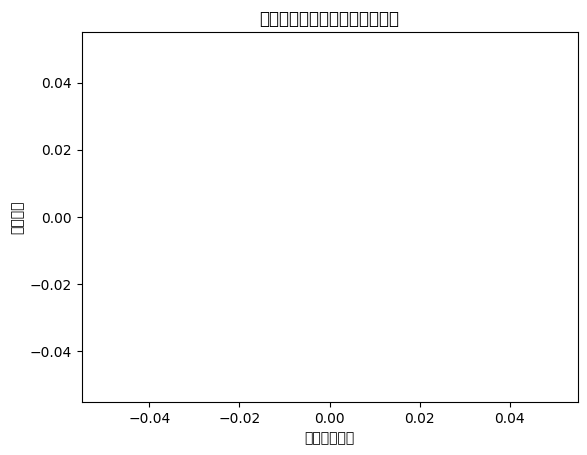

In [77]:
# クラスをインスタンス化してデータを取得
analysis = GourmetAnalysis('gourmet_ratings.db')

# 評価点数とレビュー件数の関係を取得
def fetch_reviews_and_ratings():
    query = """
    SELECT review_count, rating
    FROM gourmet_reviews
    """
    return analysis.fetch_data(query)

# データを取得
review_data = fetch_reviews_and_ratings()

# 評価点数とレビュー件数の関係をプロット
import matplotlib.pyplot as plt

plt.scatter(review_data['review_count'], review_data['rating'])
plt.title("評価点数とレビュー件数の関係")
plt.xlabel("レビュー件数")
plt.ylabel("評価点数")
plt.show()

# データベース接続を閉じる
analysis.close_connection()

In [78]:
# 各評価項目（ご当地感、味、価格、サービス、雰囲気）の平均を取得
def fetch_average_ratings():
    query = """
    SELECT AVG(local_sense) AS avg_local_sense,
           AVG(taste) AS avg_taste,
           AVG(price) AS avg_price,
           AVG(service) AS avg_service,
           AVG(atmosphere) AS avg_atmosphere
    FROM gourmet_reviews;
    """
    return analysis.fetch_data(query)

# 平均評価を取得
avg_ratings = fetch_average_ratings()
avg_ratings

ProgrammingError: Cannot operate on a closed database.

In [ ]:
# 評価点数が高いアイテムを上位5つ取得
def fetch_top_rated_items(top_n=5):
    query = f"""
    SELECT name, rating, review_count
    FROM gourmet_reviews
    ORDER BY rating DESC
    LIMIT {top_n};
    """
    return analysis.fetch_data(query)

# 上位5つのアイテムを取得
top_rated_items = fetch_top_rated_items(top_n=5)
top_rated_items